In [1]:
import pyfolio as pf
import matplotlib.pyplot as plt
import pandas as pd
import backtrader as bt
import datetime
import quantstats as qs
import backtrader.indicators as btind

c:\Users\amrit\AppData\Local\Programs\Python\Python39\lib\site-packages\quantstats\stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)
c:\Users\amrit\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
c:\Users\amrit\AppData\Local\Programs\Python\Python39\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


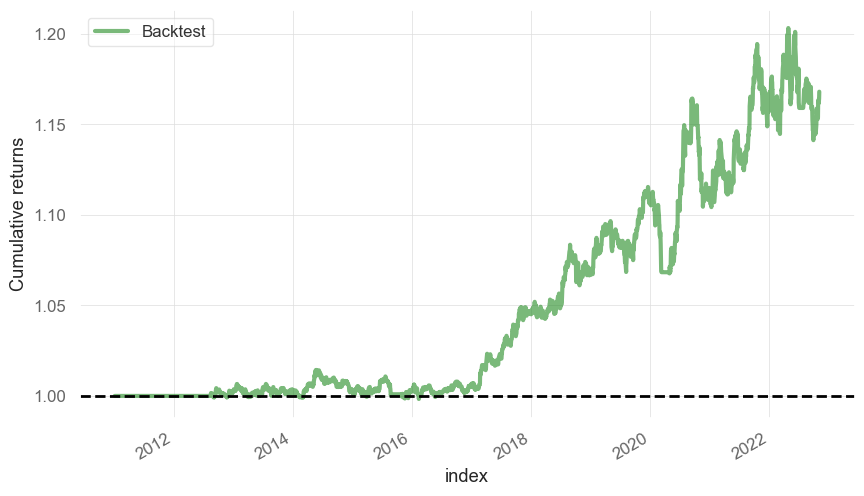

In [2]:
import backtrader as bt

class FridayTrendFollowing(bt.Strategy):
    params = (
        ('sma_period', 250),
        ('stop_loss', 0.05),
        ('take_profit', 0.10),
    )

    def __init__(self):
        self.sma = bt.indicators.SimpleMovingAverage(
            self.data.close, period=self.params.sma_period
        )

    def next(self):
        if not self.position:
            if self.data.datetime.date().weekday() == 4:
                if self.data.close[0] > self.sma[0]:
                    self.buy(target=self.data.close[0] * (1 + self.params.take_profit),
                             exectype=bt.Order.Stop)
        else:
            if self.data.close[0] < self.data.close[-1] * (1 - self.params.stop_loss):
                self.sell()

if __name__ == '__main__':
    cerebro = bt.Cerebro()

    data = bt.feeds.YahooFinanceCSVData(
        dataname='../../reliance_daily_continous.csv',
        # Do not pass values before this date
        fromdate=datetime.datetime(2011, 1, 3),
        # Do not pass values before this date
        todate=datetime.datetime(2022, 11, 7),
        # Do not pass values after this date
        reverse=False)

    cerebro.adddata(data)
    cerebro.addstrategy(FridayTrendFollowing)
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')
    results = cerebro.run()
    strat = results[0]

    portfolio_stats = strat.analyzers.getbyname('PyFolio')
    returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
    returns.index = returns.index.tz_convert(None)
    qs.reports.html(returns, output='stats.html', title='Friday Trend Following')

    '''data = cerebro.plot()
    data[0][0].savefig("friday_trend_following.png")'''

    # Plot the cumulative sum using Pyfolio
    pf.plotting.plot_rolling_returns(returns)